# I. Set ups for Data
- Create data loader


In [ ]:
import torch
from pathlib import Path

#device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

#Hyper Parameters
RAND_SEED = 420
torch.manual_seed(RAND_SEED)

In [2]:
print(device)

cuda


## 1. Data Handling Process

### 1.1 Set up for data handling process

In [3]:
import h5py

#Data paths
data_folder_path = Path("dataset")
data_path = data_folder_path / "1D_Burger_ds.hdf5"

#Data
with h5py.File(data_path,"r") as f:
  t_coor = f["t-coordinate"][:201]
  x_coor = f["x-coordinate"][:]
  sol_tensor = f["tensor"][1:,:,:]
  prototype_data = f["tensor"][0,:,:]

#Making sure t and x are sorted
t_coor.sort()
x_coor.sort()
t_coor = torch.from_numpy(t_coor)
x_coor = torch.from_numpy(x_coor)
print("Data loaded in successfully")

Data loaded in successfully


In [4]:
print(sol_tensor.shape)
print(x_coor.shape)

(9999, 201, 1024)
torch.Size([1024])


### 1.2 Datasets classes

In [5]:
#Dataset class for 1 timestep input
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch

#check if its np arr
if not isinstance(sol_tensor,np.ndarray):
  print("Conversted sol solution to np array")
  sol_tensor = np.array(sol_tensor)


class BurgerDataset_t1(Dataset):
  """Create a Pytorch dataset for a 1D Burger's equation
    Our ML model (Option 1) will:
      - Input (X): The velocity field at t=0
      - Output (Y): The entire velocity field from t=1 to t=200
  """

  def __init__(self,data_tensor):
    self.data = data_tensor

  def __len__(self):
    """Return the number of sample"""
    return self.data.shape[0]

  def __getitem__(self,idx):
    item = self.data[idx]
    x = item[0,:].astype(np.float32)
    x = np.expand_dims(x,axis=-1)
    y = item[1:, :].astype(np.float32)
    y= y.transpose(1,0)
    return torch.from_numpy(x), torch.from_numpy(y)

In [6]:
#Dataset class for N timestep input
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch

#check if its np arr
if not isinstance(sol_tensor,np.ndarray):
  print("Conversted sol solution to np array")
  sol_tensor = np.array(sol_tensor)


class BurgerDataset_tN(Dataset):
  """Create a Pytorch dataset for a 1D Burger's equation
    Our ML model (Option 1) will:
      - Input (X): The velocity field at t=0
      - Output (Y): The entire velocity field from t=1 to t=200
  """

  def __init__(self,data_tensor, t_in,t_out):
    self.data = data_tensor
    self.t_in = t_in
    self.t_out = t_out
    self.total_step = self.t_in + self.t_out

    self.num_window = self.data.shape[1] - self.total_step +1 

  def __len__(self):
    """Return the number of sample"""
    return self.data.shape[0]*self.num_window

  def __getitem__(self,idx):
    idx_sample = idx // self.num_window
    start_point = idx % self.num_window

    end_in = start_point + self.t_in
    end_out = end_in + self.t_out

    x = self.data[idx_sample,start_point:end_in,:].astype(np.float32)
    y = self.data[idx_sample,end_in:end_out,:].astype(np.float32)

    x,y= x.transpose(1,0),y.transpose(1,0)
    return torch.from_numpy(x), torch.from_numpy(y)

In [7]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch

# check if its np arr
if not isinstance(sol_tensor,np.ndarray):
  print("Conversted sol solution to np array")
  sol_tensor = np.array(sol_tensor)

class BurgerDataset_Autoregressive_Sparse(Dataset):
    """
    A *faster* sliding window dataset (e.g., 10-in, 1-out).
    It creates a smaller, randomized dataset of (N_sims * windows_per_sim) samples.
    """
    def __init__(self, data_tensor, t_in=10, t_out=1, windows_per_sim=20):
        self.data = data_tensor # Shape: (Num_Sims, 201, 1024)
        self.t_in = t_in
        self.t_out = t_out
        self.total_steps = t_in + t_out # 11 steps total
        
        # Max possible start time: (201 - 11) = 190
        self.max_start_time = self.data.shape[1] - self.total_steps 
        
        self.sims_in_dataset = self.data.shape[0]
        self.windows_per_sim = windows_per_sim
        
        # Total length of the dataset is now much smaller
        self.length = self.sims_in_dataset * self.windows_per_sim
        # e.g., 1000 sims * 20 windows/sim = 20,000 samples

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 1. Figure out which simulation this index belongs to
        sim_index = idx // self.windows_per_sim
        
        # 2. Pick a RANDOM start time for the window
        # This makes the dataset different every epoch, which is good for training
        start_time_index = np.random.randint(0, self.max_start_time + 1)
        
        # 3. Define the end of the input and output slices
        end_in_index = start_time_index + self.t_in   # e.g., 50 + 10 = 60
        end_out_index = end_in_index + self.t_out    # e.g., 60 + 1 = 61

        # 4. Get the data chunks
        x_np = self.data[sim_index, start_time_index : end_in_index, :].astype(np.float32) # Shape (10, 1024)
        y_np = self.data[sim_index, end_in_index : end_out_index, :].astype(np.float32)   # Shape (1, 1024)
        
        # 5. Transpose to (Points, Channels/Time) format
        x = x_np.transpose(1, 0) # Shape (1024, 10)
        y = y_np.transpose(1, 0) # Shape (1024, 1)
        
        return torch.from_numpy(x), torch.from_numpy(y)

print("BurgerDataset_Autoregressive_Sparse (FASTER dataset) defined.")

BurgerDataset_Autoregressive_Sparse (FASTER dataset) defined.


# II. Set up for model
- Declare up model class
- Set up loss functions
- Train - test function


## 1.Models set ups

### 1.1 FNO1D layer class

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
class FNO_Layer1D(nn.Module):
  """ A class act as one Fourier Layer as described in the original paper"""
  def __init__(self,in_chanels, out_chanels,modes):
    super(FNO_Layer1D, self).__init__()
    self.in_chanels = in_chanels
    self.out_chanels = out_chanels
    self.modes = modes
    #Scaler to scale the parameters
    self.scalar = (1/(in_chanels * out_chanels))
    self.weights = nn.Parameter(
        self.scalar * torch.rand(in_chanels,out_chanels,modes,dtype = torch.cfloat)
    )

  def forward(self, x):
    # FFT (1D fourier transform)
    x_ft = torch.fft.rfft(x)

    batch_size = x.shape[0]
    num_points = x.shape[-1]

    ## Fourier layer
    out_ft = torch.zeros(
        batch_size, self.out_chanels, num_points//2 +1,
        dtype = torch.cfloat,
        device = device
    )

    out_ft[:,:,:self.modes] = torch.einsum(
        "bim,iom->bom",
        x_ft[:,:,:self.modes]
        , self.weights
    )

    ## Inverse FFT
    x = torch.fft.irfft(out_ft)
    return x
print("FNO_Layer1D class defined.")

FNO_Layer1D class defined.


### 1.2 FNO1D class

In [9]:
class FNO1D(nn.Module):
  def __init__(self ,width, modes, x_coor,in_chanels =1, out_chanels =200) :
    """ Default is 1 time step -> 200 timestep rest"""
    super(FNO1D,self).__init__()
    self.in_chanels = in_chanels + 1 # add one more for the x_grid
    self.out_chanels = out_chanels
    self.width = width
    self.modes = modes

    self.register_buffer('x_coor', x_coor)

    # P layer ( lift the input chanel up):
    self.fc0 = nn.Linear(self.in_chanels, self.width)

    # T block: 4 Fourier layers
    self.conv0 = FNO_Layer1D(width,width,modes)
    self.w0 = nn.Conv1d(self.width,self.width,1)

    self.conv1 = FNO_Layer1D(width,width,modes)
    self.w1 = nn.Conv1d(self.width,self.width,1)

    self.conv2 = FNO_Layer1D(width,width,modes)
    self.w2 = nn.Conv1d(self.width,self.width,1)

    self.conv3 = FNO_Layer1D(width,width,modes)
    self.w3 = nn.Conv1d(self.width,self.width,1)

    # Q layer (project down to output_chanels)
    self.fc1 = nn.Linear(width,width*2)
    self.fc2 = nn.Linear(width*2, self.out_chanels)

  def forward(self,x):
    batch_size = x.shape[0]

    #Get the grid information
    grid = self.x_coor.unsqueeze(dim=-1).repeat(batch_size,1,1) # (batch,1024,1)

    # concat to the input
    x = torch.cat((x,grid),dim=-1) # (batch,1024,2)

    ##Through P layer:
    x = self.fc0(x)

    x = x.permute(0,2,1) #(B,2,1024)

    ##Through T
    #1
    x1 = self.conv0(x)
    x2 = self.w0(x)
    x = x1+x2
    x = F.gelu(x)

    #2
    x1 = self.conv1(x)
    x2 = self.w1(x)
    x = x1+x2
    x = F.gelu(x)

    #3
    x1 = self.conv2(x)
    x2 = self.w2(x)
    x = x1+x2
    x = F.gelu(x)

    #4
    x1 = self.conv3(x)
    x2 = self.w3(x)
    x = x1+x2

    #Switch back
    x = x.permute(0, 2, 1) # (batch, 1024, width)

    ## Through Q
    x = self.fc1(x)
    x = F.gelu(x)
    x = self.fc2(x)
    return x

print("FNO1D class defined.")

FNO1D class defined.


## 2.Loss functions


In [10]:
class LpLoss(object):
    """
    A class to compute the relative L2 loss (data loss).
    Calculates: mean( ||y_pred - y_true|| / ||y_true|| )
    """
    def __init__(self, size_average=True, d=2, p=2):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p
        self.size_average = size_average

    def cal_data_loss(self, y_pred, y_label):
        """
        Calculates the relative L2 error.
        y_pred: (Batch, Space, Time)
        y_label: (Batch, Space, Time)
        """

        # torch.norm(..., dim=(1,2)) calculates the L2 norm (length)
        # of the error for each sample in the batch across both
        # time and space dimensions.
        # Shape: (Batch,)
        diff_norms = torch.norm(y_pred - y_label, self.p, dim=(1, 2))
        y_label_norms = torch.norm(y_label, self.p, dim=(1, 2))

        # Calculate the relative error for each sample
        # We add a small epsilon to avoid division by zero
        rel_error = diff_norms / (y_label_norms + 1e-7)

        if self.size_average:
            # Return the average relative error across the batch
            return torch.mean(rel_error)
        else:
            # Return the sum of relative errors
            return torch.sum(rel_error)

    def __call__(self, x, y):
        return self.cal_data_loss(x, y)

### 2.1 DATA only loss fn

In [11]:
from torch import nn
# This is the loss function for Model 0
class DataOnlyLoss(nn.Module):
    def __init__(self, size_average=True):
        super(DataOnlyLoss, self).__init__()
        self.data_loss_fn = LpLoss(size_average)

    def forward(self, x_in, y_pred, y_true):
        # Calculate the data loss
        data_loss = self.data_loss_fn(y_pred, y_true)

        # Return 0.0 for the physics loss
        return data_loss, 0.0

### 2.2 Burgerloss fn

In [12]:
## PINO loss function
class BurgerLoss(nn.Module):
    def __init__(self, t_coord, x_coord, viscosity=0.01, size_average=True):
        super(BurgerLoss, self).__init__()

        self.t_coord = t_coord
        self.x_coord = x_coord
        self.size_average = size_average
        self.viscosity = viscosity # Store viscosity

        # Calculate time step (dt) and space step (dx)
        self.dt = (t_coord[1] - t_coord[0]).item()
        self.dx = (x_coord[1] - x_coord[0]).item()

        print(f"Physics Loss Initialized:")
        print(f"  dt = {self.dt:.4f}")
        print(f"  dx = {self.dx:.4f}")
        print(f"  viscosity (nu) = {self.viscosity}")

        self.data_loss_fn = LpLoss(self.size_average)

    def cal_residual_loss(self, u):
        """
        Calculates the physics residual of the Burgers' equation:
        f = u_t + u * u_x - nu * u_xx

        We use central differences to approximate the derivatives.
        u shape is (Batch, Space, Time), e.g., (32, 1024, 201)
        """

        # --- 1. Calculate du/dt (Time derivative) ---
        # Slicing on dim=2 (Time)
        # Formula: (f(t+1) - f(t-1)) / (2*dt)
        u_t = (u[:, :, 2:] - u[:, :, :-2]) / (2 * self.dt)

        # --- 2. Calculate du/dx (Space derivative) ---
        # Slicing on dim=1 (Space)
        # Formula: (f(x+1) - f(x-1)) / (2*dx)
        u_x = (u[:, 2:, :] - u[:, :-2, :]) / (2 * self.dx)

        # --- 3. Calculate d2u/dx2 (Second space derivative) ---
        # Slicing on dim=1 (Space)
        # Formula: (f(x+1) - 2*f(x) + f(x-1)) / (dx^2)
        u_xx = (u[:, 2:, :] - 2 * u[:, 1:-1, :] + u[:, :-2, :]) / (self.dx**2)

        # --- 4. Align Tensors ---
        # All tensors must be on the common "inner" grid: (B, 1022, 199)
        # We lose 2 points in Space (dim=1) and 2 in Time (dim=2)

        # slice both X and T
        u_inner = u[:, 1:-1, 1:-1] 

        # slice only in X
        u_t_inner = u_t[:, 1:-1, :]  

        # slice only in T
        u_x_inner = u_x[:, :, 1:-1]  

        # slice only in T
        u_xx_inner = u_xx[:, :, 1:-1] 

        # --- 5. Calculate Residual ---
        residual = u_t_inner + u_inner * u_x_inner - self.viscosity * u_xx_inner
        return residual

    def forward(self, x_in, y_pred, y_true):
        """
        Calculates the total loss.
        x_in:   Input (t=0). Shape (B,1024,1)
        y_pred: Prediction (t=1..200). Shape (B, 1024, 200)
        y_true: Ground truth (t=1..200). Shape (B, 1024, 200 )
        """

        # 1. Data Loss (L_data)
        # This is correct. LpLoss will compare (B, 1024, 200) tensors.
        data_loss = self.data_loss_fn(y_pred, y_true)

        # 2. Physics Loss (L_physics)

        u_full_pred = torch.cat((x_in, y_pred), dim=2) # Shape: (B, 1024, 201)

        # Calculate the residual
        residual = self.cal_residual_loss(u_full_pred)

        # Physics loss is the MSE of the residual
        physics_loss = F.mse_loss(residual, torch.zeros_like(residual))

        return data_loss, physics_loss

## 3 Training & Evaluating process

### 3.1 Training and testing loops + printing time method

In [14]:
# TRAINING LOOP (Physics-Informed Experience Learning - PIEL)
def training_loop(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  phys_weight:float,
                  loss_fn : torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  device):
    
    # --- INITIALIZATION ---
    model.train()
    
    # --- BATCH ITERATION ---
    for batch, (x_batch_in, y_batch_target) in enumerate(data_loader):
        x_batch_in, y_batch_target = x_batch_in.to(device), y_batch_target.to(device)

        # forward  
        y_pred = model(x_batch_in) 

        #Loss 
        data_loss, phys_loss = loss_fn(x_batch_in, y_pred,y_batch_target)
        total_loss = data_loss + phys_weight*phys_loss
        
        # 5. Backward Pass and Optimization (Done once per batch for the full accumulated rollout loss)
        optimizer.zero_grad()
        total_loss.backward() 
        optimizer.step()

        #6. Accumulate 
        train_data_loss += data_loss
        phys_data_loss += phys_loss
        
    # --- SCALING FOR REPORTING (Average over all steps and batches) ---
    train_data_loss = total_data_loss_epoch / len(data_loader)
    train_phys_loss = total_phys_loss_epoch / len(data_loader)

    return train_data_loss, train_phys_loss

In [15]:
#Testing loop
def testing_loop(model:torch.nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn:torch.nn.Module,
                 device):

  model.eval()
  val_data_loss = 0
  with torch.inference_mode(): # Disable gradient calculation
    for batch,(x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = model(x_batch)

        # We only care about the data loss for validation
        data_loss, _ = loss_fn(x_batch, y_pred, y_batch)

        #Accumulating
        val_data_loss += data_loss.item()


  #Scaling
  val_data_loss /= len(data_loader)

  return val_data_loss


In [16]:
def printing_time(start, end, model_name):
    print(f"It takes {(end-start):.2f} s to train {model_name}")

### 3.2 Traing & validating for epochs



In [17]:
import torch
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_and_test(lr_scheduler, model: torch.nn.Module,
                   loss_fn:torch.nn.Module, optimizer: torch.optim.Optimizer,phys_weight :float, train_loader,
                   dev_loader, epochs = 100, device = device):
  #Setups
  model.to(device)

  results = {
      "train_data_loss":[],
      "train_phys_loss":[],
      "val_data_loss":[],
  }

  #Start timing
  start_time = timer()

  #Start
  for epoch in tqdm(range(epochs)):
    if epoch %8 == 0:
      print("--------------------------")
      print(f"Epoch: {epoch}\n--------------")
        
      sampling_prob -=0.1

    #Training
    train_data_loss, train_phys_loss = training_loop(model,train_loader, phys_weight, loss_fn, optimizer,device)

    #Testing
    val_data_loss = testing_loop(model,dev_loader,loss_fn,device)

    #Decay lr based on val_loss
    lr_scheduler.step(val_data_loss)

    #Printing
    if epoch % 8 ==0:
      print(f"Train data Loss:{train_data_loss:.3f} || Train physic Loss:{train_phys_loss:.3f} || Test Loss:{val_data_loss:.3f}")

    #Restore values
    results["train_data_loss"].append(train_data_loss.item() if isinstance(train_data_loss, torch.Tensor) else train_data_loss)
    results["train_phys_loss"].append(train_phys_loss.item() if isinstance(train_phys_loss, torch.Tensor) else train_phys_loss)
    results["val_data_loss"].append(val_data_loss.item() if isinstance(val_data_loss, torch.Tensor) else val_data_loss)

  #Printing time
  print("--------------------------")
  end_time = timer()
  printing_time(start_time,end_time,type(model).__name__)

  return results


### 3.3 Evaluating model function

In [18]:
def evaluating(model: torch.nn.Module, loss_fn:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader, device =device):

  model.to(device)

  test_loss =0

  #Evaluating
  model.eval()
  with torch.inference_mode():
    for x_batch, y_batch in data_loader:
      x_batch , y_batch = x_batch.to(device), y_batch.to(device)


      #Forward
      y_pred = model(x_batch)

      #Loss and acc
      loss,_= loss_fn(x_batch,y_pred,y_batch)
      test_loss += loss
  print("Finished evaluating your model")

  return {"model" : model.__class__.__name__,
          "loss":test_loss.item()/len(data_loader)}

# III. Models 1D

## 1.DATA

### 1.1 T1 data

In [19]:
#Data for model using 1time step input
data_t1 = BurgerDataset_t1(sol_tensor)

# Attribute of dataset
total_len = len(data_t1)
train_size = int(total_len * 0.6 )
dev_size = int(total_len *0.2)
test_size = total_len - train_size - dev_size
BATCH_SIZE = 32
print(f"Number of samples: {total_len}")

#Split datasets
train_dataset_t1 , dev_dataset_t1, test_dataset_t1 = random_split(data_t1, [train_size, dev_size, test_size])


# Generating loader
g = torch.Generator()
g.manual_seed(RAND_SEED)

train_loader_t1 = DataLoader(
    dataset = train_dataset_t1,
    batch_size = BATCH_SIZE,
    shuffle  = True,
    num_workers = 0,
    generator = g
)

dev_loader_t1 = DataLoader(
    dataset = dev_dataset_t1,
    batch_size = BATCH_SIZE,
    shuffle  = False,
    num_workers = 0,
    generator = g

)

test_loader_t1 = DataLoader(
    dataset = test_dataset_t1,
    batch_size = BATCH_SIZE,
    shuffle  = False,
    num_workers =0,
    generator = g
)

x_z,y_z = next(iter(train_loader_t1))
print(x_z.shape)
print(y_z.shape)
print("\nDataLoaders1t created successfully.")

Number of samples: 9999
torch.Size([32, 1024, 1])
torch.Size([32, 1024, 200])

DataLoaders1t created successfully.


## 2.Based Model 0.
- FNO1D using only L2 loss
- dataset_t1
- 30 epochs
- input t=1, output the rest t

### 2.1 loss_fn Optimizer and lr scheduler


In [44]:
## HYPER Parameters from the paper
WIDTH =64
K_MAX =24

#Define model
model0a = FNO1D(WIDTH,K_MAX,x_coor).to(device)

In [45]:
loss_fn0 = DataOnlyLoss(size_average=True).to(device)

In [46]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Optimizer (Adam)
LR =0.001
optimizer0 = torch.optim.Adam(model0a.parameters(),lr = LR)

# We'll use 'ReduceLROnPlateau'.
# This scheduler will automatically "reduce" the learning rate
# when it detects that our validation loss has "plateaued" (stopped improving).
scheduler0 = ReduceLROnPlateau(
    optimizer0,
    mode='min',      # It will look at the validation loss, where 'min' is better
    factor=0.1,      # Reduce LR by a factor of 10 (e.g., 0.001 -> 0.0001)
    patience=5,      # Wait 5 epochs for improvement before reducing
)

### 2.2 Train and test model 0


In [43]:
result0a = train_and_test(scheduler0, model = model0a,
              loss_fn = loss_fn0, optimizer = optimizer0,phys_weight = 1.0, train_loader = train_loader_t1,
              dev_loader = dev_loader_t1, epochs = 150,device = device)

  0%|          | 0/150 [00:00<?, ?it/s]

--------------------------
Epoch: 0
--------------
Train data Loss:0.419 || Train physic Loss:0.000 || Test Loss:0.273
--------------------------
Epoch: 10
--------------
Train data Loss:0.134 || Train physic Loss:0.000 || Test Loss:0.164
--------------------------
Epoch: 20
--------------
Train data Loss:0.108 || Train physic Loss:0.000 || Test Loss:0.113
--------------------------
Epoch: 30
--------------
Train data Loss:0.095 || Train physic Loss:0.000 || Test Loss:0.181
--------------------------
Epoch: 40
--------------
Train data Loss:0.088 || Train physic Loss:0.000 || Test Loss:0.089
--------------------------
Epoch: 50
--------------
Train data Loss:0.082 || Train physic Loss:0.000 || Test Loss:0.083
--------------------------
Epoch: 60
--------------
Train data Loss:0.077 || Train physic Loss:0.000 || Test Loss:0.084
--------------------------
Epoch: 70
--------------
Train data Loss:0.062 || Train physic Loss:0.000 || Test Loss:0.069
--------------------------
Epoch: 80
----

In [44]:
print(f"Result 0: {result0a}")

Result 0: {'train_data_loss': [0.4190126657485962, 0.2438027709722519, 0.2053542137145996, 0.18745005130767822, 0.17315584421157837, 0.16778169572353363, 0.15546777844429016, 0.14913244545459747, 0.14354567229747772, 0.1425890028476715, 0.13358086347579956, 0.13522657752037048, 0.12482002377510071, 0.12956371903419495, 0.1252528876066208, 0.12121507525444031, 0.1207222267985344, 0.11314056068658829, 0.11386848986148834, 0.1155693307518959, 0.10823304951190948, 0.10700380802154541, 0.10686203092336655, 0.10777382552623749, 0.10113515704870224, 0.10435977578163147, 0.09751438349485397, 0.10116107016801834, 0.09645455330610275, 0.09523839503526688, 0.09458483010530472, 0.11452236026525497, 0.09390430897474289, 0.09262383729219437, 0.09398110955953598, 0.08744456619024277, 0.09011059999465942, 0.09024737775325775, 0.08545702695846558, 0.08795303851366043, 0.08832742273807526, 0.08837851136922836, 0.08837467432022095, 0.08694621920585632, 0.08385656774044037, 0.08178891986608505, 0.08499378

In [45]:
evaluating(model = model0, loss_fn=loss_fn0,
               data_loader=test_loader_t1, device =device)

Finished evaluating your model


{'model': 'FNO1D', 'loss': 1.0283114720904638}

## 3.Model 1
- FNO1D with physics loss
- dataset t1
- 30 epochs
- input t=1, output the rest t
- mui = 0.01

### 3.1 Loss function and optimizer

In [ ]:
## HYPER Parameters from the paper
WIDTH =64
K_MAX =16

#Define model
model1 = FNO1D(WIDTH,K_MAX,x_coor).to(device)

In [ ]:
loss_fn1 = BurgerLoss(t_coor,x_coor,0.01)

In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

#Optimizer (Adam)
LR =0.001
optimizer1 = torch.optim.Adam(model1.parameters(),lr = LR)

# We'll use 'ReduceLROnPlateau'.
# This scheduler will automatically "reduce" the learning rate
# when it detects that our validation loss has "plateaued" (stopped improving).
scheduler1 = ReduceLROnPlateau(
    optimizer1,
    mode='min',      # It will look at the validation loss, where 'min' is better
    factor=0.1,      # Reduce LR by a factor of 10 (e.g., 0.001 -> 0.0001)
    patience=5,      # Wait 5 epochs for improvement before reducing
)

### 3.2 Training and testing model 1

In [ ]:
#Converge at around epoch 115
result1 = train_and_test(scheduler1, model = model1,
              loss_fn = loss_fn1, optimizer = optimizer1,phys_weight = 0.01, train_loader = train_loader_t1,
              dev_loader = dev_loader_t1, epochs = 150,device = device)

In [ ]:
evaluating(model = model1, loss_fn=loss_fn1,
               data_loader=test_loader_t1, device =device)

## 4. Saving and comparing models

### 4.1 Saving model

In [54]:
import torch
import os

print("Saving initial untrained models...")

# 1. Define a path to save your models in your Drive
MODELS_PATH = Path("models")
os.makedirs(MODELS_PATH, exist_ok=True)

# 2. Define the save paths for each model
MODEL0_SAVE_PATH = MODELS_PATH / "model0_initial_state.pth"
MODEL1_SAVE_PATH = MODELS_PATH / "model1_initial_state.pth"

# 3. Save the models' state dictionaries
# .state_dict() saves only the learnable parameters (weights and biases)
try:
    torch.save(model2.state_dict(), MODEL2_SAVE_PATH)
    print(f"Successfully saved model0 to: {MODEL0_SAVE_PATH}")
    print(f"Successfully saved model1 to: {MODEL1_SAVE_PATH}")
except Exception as e:
    print(f"Error saving models: {e}")

# To load them back later (for inference or to resume training), you would:
# 1. Re-create the model instance: model0 = FNO1D(WIDTH, K_MAX, x_grid_tensor).to(device)
# 2. Load the weights: model0.load_state_dict(torch.load(MODEL0_SAVE_PATH))

Saving initial untrained models...
Successfully saved model0 to: models\model0_initial_state.pth
Successfully saved model1 to: models\model1_initial_state.pth
Successfully saved model2 to: models\model2_initial_state.pth


### 4.2 Compare models

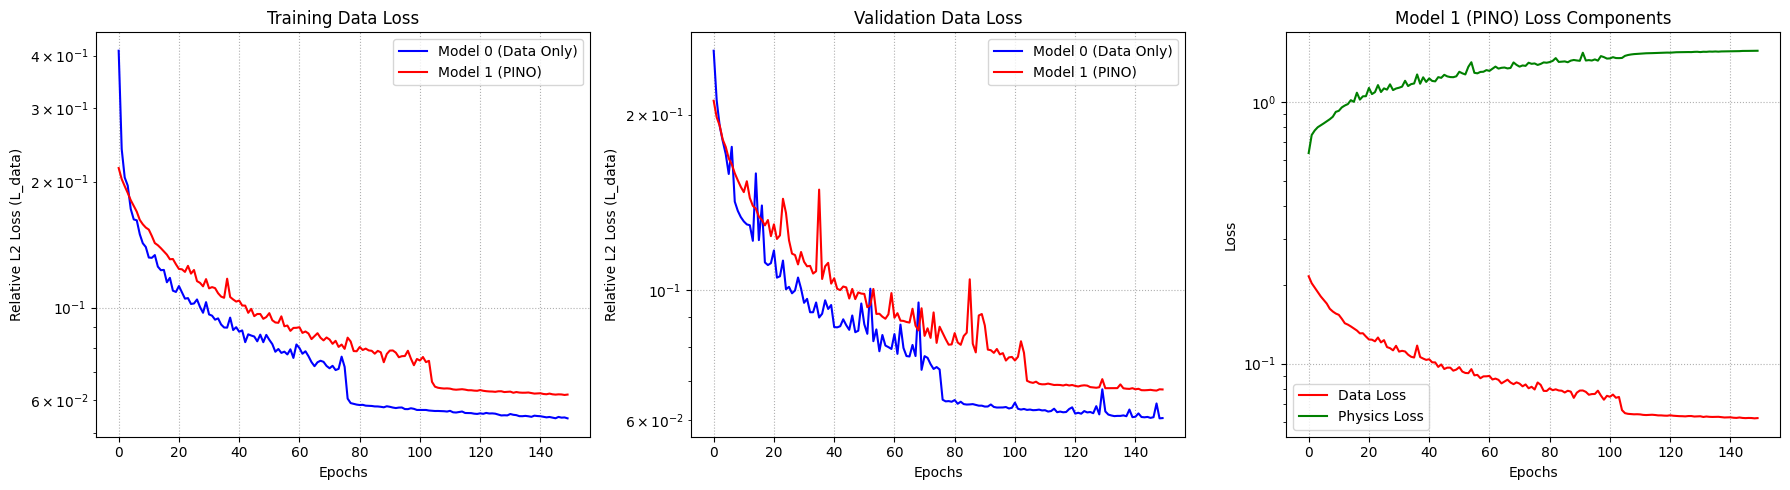

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from results import result1, result0

# --- IMPORTANT ---
# You must copy the dictionary outputs from your notebook cells
# (cell 50 for model0 and cell 67 for model1) and paste them here.
# I have used your completed output from cell 50 as an example.
# You will need to replace results_1 with your full 30-epoch output.

# --- Create Epoch Array ---
# Assumes both models were trained for the same number of epochs
result0 = {'train_data_loss': [0.4110739827156067, 0.23925882577896118, 0.20458190143108368, 0.19567212462425232, 0.17208527028560638, 0.16243018209934235, 0.16161102056503296, 0.1497381031513214, 0.1424730122089386, 0.13952957093715668, 0.13167569041252136, 0.1314629167318344, 0.13347485661506653, 0.1252565085887909, 0.12282412499189377, 0.12299676984548569, 0.11490682512521744, 0.11774254590272903, 0.10972394794225693, 0.10895457118749619, 0.11255241930484772, 0.10872527211904526, 0.10500839352607727, 0.10531488806009293, 0.10197656601667404, 0.10225849598646164, 0.10453744977712631, 0.10029015690088272, 0.09715524315834045, 0.10300806164741516, 0.09627469629049301, 0.09561239928007126, 0.09352393448352814, 0.09420380741357803, 0.09108910709619522, 0.08958891034126282, 0.08952014893293381, 0.0945991724729538, 0.08834867179393768, 0.08973327279090881, 0.08752944320440292, 0.08816472440958023, 0.08264376223087311, 0.08628880232572556, 0.08571340143680573, 0.08524730801582336, 0.08302949368953705, 0.08613189309835434, 0.08262985199689865, 0.0860193744301796, 0.08372187614440918, 0.08175082504749298, 0.0784018486738205, 0.07959341257810593, 0.0778963565826416, 0.0784391239285469, 0.07724633812904358, 0.07945655286312103, 0.07577656954526901, 0.08160007745027542, 0.08002155274152756, 0.07753711193799973, 0.07859975844621658, 0.0764986202120781, 0.07406435161828995, 0.0723976269364357, 0.0739876925945282, 0.07461126893758774, 0.07415719330310822, 0.07250193506479263, 0.07158296555280685, 0.0725533589720726, 0.07088251411914825, 0.0713513195514679, 0.07630784064531326, 0.07213081419467926, 0.06057237461209297, 0.05909671634435654, 0.05885971337556839, 0.058606330305337906, 0.05847145989537239, 0.058534953743219376, 0.05826769769191742, 0.05820904299616814, 0.05816391482949257, 0.05802098661661148, 0.058009110391139984, 0.057899314910173416, 0.0577441044151783, 0.05807175859808922, 0.057901881635189056, 0.05766398832201958, 0.05750136449933052, 0.05765574425458908, 0.05767909809947014, 0.05718502774834633, 0.0571594312787056, 0.057440076023340225, 0.057252444326877594, 0.05690488591790199, 0.05690895393490791, 0.05691118910908699, 0.056899115443229675, 0.05672742426395416, 0.05663994699716568, 0.05657578259706497, 0.05658656731247902, 0.05656237527728081, 0.05650690570473671, 0.05641086399555206, 0.056626658886671066, 0.05617628991603851, 0.05610703304409981, 0.05624675750732422, 0.0564168281853199, 0.05596563592553139, 0.05595419928431511, 0.055922769010066986, 0.05574888736009598, 0.05567246302962303, 0.05585700646042824, 0.055710289627313614, 0.05597971752285957, 0.05580592527985573, 0.05584094300866127, 0.05574943125247955, 0.05546464025974274, 0.055211909115314484, 0.05526223033666611, 0.05522475764155388, 0.05564416944980621, 0.05541204661130905, 0.05530177429318428, 0.05499405786395073, 0.05497822165489197, 0.055076297372579575, 0.05496148020029068, 0.0547984354197979, 0.05514082685112953, 0.055032216012477875, 0.05497255548834801, 0.05481015145778656, 0.05463377758860588, 0.054746970534324646, 0.05454118177294731, 0.05435951054096222, 0.05476135388016701, 0.054547540843486786, 0.05460606887936592, 0.05433722585439682], 'train_phys_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_data_loss': [0.2572142621354451, 0.21145666733620658, 0.19115776675088064, 0.1802690809681302, 0.17118003964424133, 0.15824853404173775, 0.17612133447139983, 0.14190959067098677, 0.13687605919345977, 0.1335370416442553, 0.13127026198402283, 0.1297357457261237, 0.12929621764591762, 0.12160444259643555, 0.15860963624621194, 0.12193896668770957, 0.13977357768823231, 0.11167937008634446, 0.11051414717757513, 0.11135667432395238, 0.11710662323804129, 0.10518188218748759, 0.10574372337451057, 0.11249114868659822, 0.10047837618797545, 0.10142433477772607, 0.09888798826270634, 0.09998914327413316, 0.10522396519543632, 0.10073239829332109, 0.09524016141418427, 0.09673324570296303, 0.0917700073785252, 0.09177173449406548, 0.09537116840245231, 0.0898829839295811, 0.09122747289282936, 0.09619156460440348, 0.09295563683623359, 0.09442581981420517, 0.0865695761546256, 0.08646621212126716, 0.08684119321997204, 0.089255215156646, 0.0872151656519799, 0.08562316390730086, 0.0906154742789647, 0.08481654382887341, 0.08532685396217164, 0.09498826461651969, 0.08751835993358068, 0.08428332919166201, 0.10068383375330577, 0.08187451710303624, 0.08577221821224879, 0.07869435054442239, 0.08390380430316167, 0.08048265462829954, 0.07998732867695037, 0.07940924309548877, 0.08420824247693258, 0.07788392381062584, 0.08739961293481645, 0.07972035036673622, 0.07721601213727679, 0.07708905519001068, 0.08067990259991752, 0.07722300066361351, 0.09537790822131294, 0.07313832954045325, 0.07719190785336116, 0.0766766376438595, 0.07478425805530851, 0.0733860337308475, 0.07394332036612526, 0.07324050420096942, 0.06501247840268272, 0.06459305080629531, 0.06465581023976916, 0.06449638975281564, 0.06492461772665145, 0.06398267458592143, 0.0644972435538731, 0.06389726597874884, 0.06378511274381289, 0.06382066389871022, 0.06389406625004042, 0.06369595667199483, 0.06350627009357725, 0.0635057757534678, 0.06327962041610763, 0.06329736746256313, 0.06380144559911319, 0.06318371796182223, 0.06303894472500635, 0.06305838967599565, 0.06306172854134015, 0.06316362587468964, 0.06280702772358107, 0.06297555837839369, 0.06427314351238901, 0.06272708405814474, 0.06253687392861124, 0.06268517643449799, 0.062455795646186855, 0.06254122944341765, 0.06238306195489944, 0.06241820912275996, 0.062523636493891, 0.06233104856477843, 0.0623762799752137, 0.06204700215704857, 0.06217261888678112, 0.06274812715867209, 0.0618926150694726, 0.06204395309563667, 0.06187254799500344, 0.061938941537860844, 0.06266835385135242, 0.06309285830883753, 0.06154843940148278, 0.06175081975876339, 0.06152673846199399, 0.06216449757653569, 0.06183923437954888, 0.06193630456451386, 0.06164784404256987, 0.06338022170322281, 0.06135745565333064, 0.06773435566869992, 0.06207913467808375, 0.0613168551926575, 0.061097964880958436, 0.06094158074212453, 0.06099840265417856, 0.06099581180347337, 0.06111503788639629, 0.06091841511310093, 0.06254472116392756, 0.06069481703970167, 0.060798205198749664, 0.0615965946917496, 0.060730867383499, 0.06066012004065135, 0.06074823173029082, 0.0605203460842844, 0.060685241033160496, 0.06406244617842492, 0.06041179910775215, 0.06047245848273474]}

epochs = range(len(result0['train_data_loss']))


# --- Create Plots ---
plt.figure(figsize=(18, 5))

# Plot 1: Training Data Loss Comparison
plt.subplot(1, 3, 1)
plt.plot(epochs, result0['train_data_loss'], label='Model 0 (Data Only)', color='blue')
plt.plot(epochs, result1['train_data_loss'], label='Model 1 (PINO)', color='red')
plt.title('Training Data Loss')
plt.xlabel('Epochs')
plt.ylabel('Relative L2 Loss (L_data)')
plt.legend()
plt.grid(True, linestyle=':')
plt.yscale('log') # Use log scale if losses are very different

# Plot 2: Validation Data Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(epochs, result0['val_data_loss'], label='Model 0 (Data Only)', color='blue')
plt.plot(epochs, result1['val_data_loss'], label='Model 1 (PINO)', color='red')
plt.title('Validation Data Loss')
plt.xlabel('Epochs')
plt.ylabel('Relative L2 Loss (L_data)')
plt.legend()
plt.grid(True, linestyle=':')
plt.yscale('log')

# Plot 3: Model 1 (PINO) Loss Breakdown
plt.subplot(1, 3, 3)
plt.plot(epochs, result1['train_data_loss'], label='Data Loss', color='red')
plt.plot(epochs, result1['train_phys_loss'], label='Physics Loss', color='green')
plt.title('Model 1 (PINO) Loss Components')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle=':')
plt.yscale('log') # Log scale is essential here since physics loss is large



plt.tight_layout()
plt.show()